# Kütüphanelerin ve Veri Setinin Yüklenmesi

In [1]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import AdamW


In [2]:
with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')
img_path="/kaggle/working/plates/train/"
labels = ['cleaned', 'dirty']
def set_df(dir):
    img_list=[]
    label_list=[]
    for label in labels:
        for img_file in os.listdir(dir+label):
            if img_file.endswith('.jpg'):
                img_list.append(dir+label+"/"+img_file)
                label_list.append(label)
    df=pd.DataFrame({"img":img_list, "label":label_list})
    return df

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Görüntü boyutunu ayarla
    transforms.ToTensor(),         # Görüntüyü tensöre dönüştür
    transforms.Normalize((0.5,), (0.5,))  # Normalize et
])

# Veri Setini Ayıklama ve Görselleştirme 

In [3]:
df=set_df(img_path)
d={"dirty":1, "cleaned":0}
df["encode_label"]= df["label"].map(d)

In [4]:
df.head(10)


,img,label,encode_label
0,/kaggle/working/plates/train/cleaned/0000.jpg,cleaned,0
1,/kaggle/working/plates/train/cleaned/0002.jpg,cleaned,0
2,/kaggle/working/plates/train/cleaned/0003.jpg,cleaned,0
3,/kaggle/working/plates/train/cleaned/0010.jpg,cleaned,0
4,/kaggle/working/plates/train/cleaned/0013.jpg,cleaned,0
5,/kaggle/working/plates/train/cleaned/0018.jpg,cleaned,0
6,/kaggle/working/plates/train/cleaned/0001.jpg,cleaned,0
7,/kaggle/working/plates/train/cleaned/0011.jpg,cleaned,0
8,/kaggle/working/plates/train/cleaned/0014.jpg,cleaned,0
9,/kaggle/working/plates/train/cleaned/0019.jpg,cleaned,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img           40 non-null     object
 1   label         40 non-null     object
 2   encode_label  40 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ KB


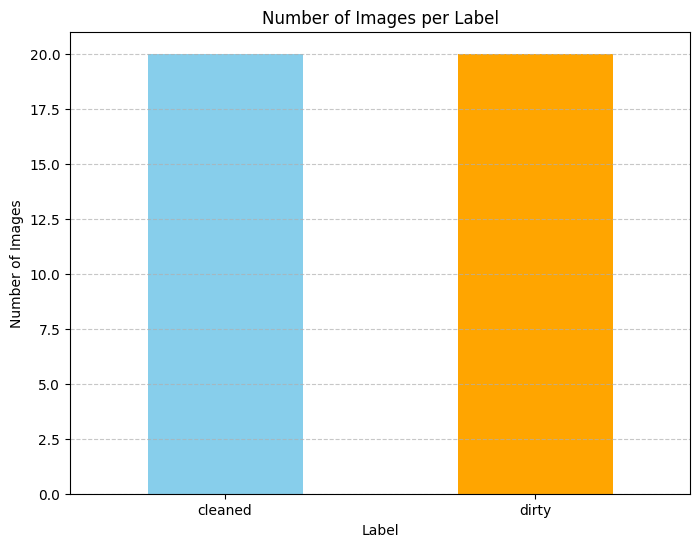

In [6]:

# Her labelden kaç görsel olduğunu sayıyoruz
label_counts = df['label'].value_counts()

# Görselleştirme
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Number of Images per Label')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


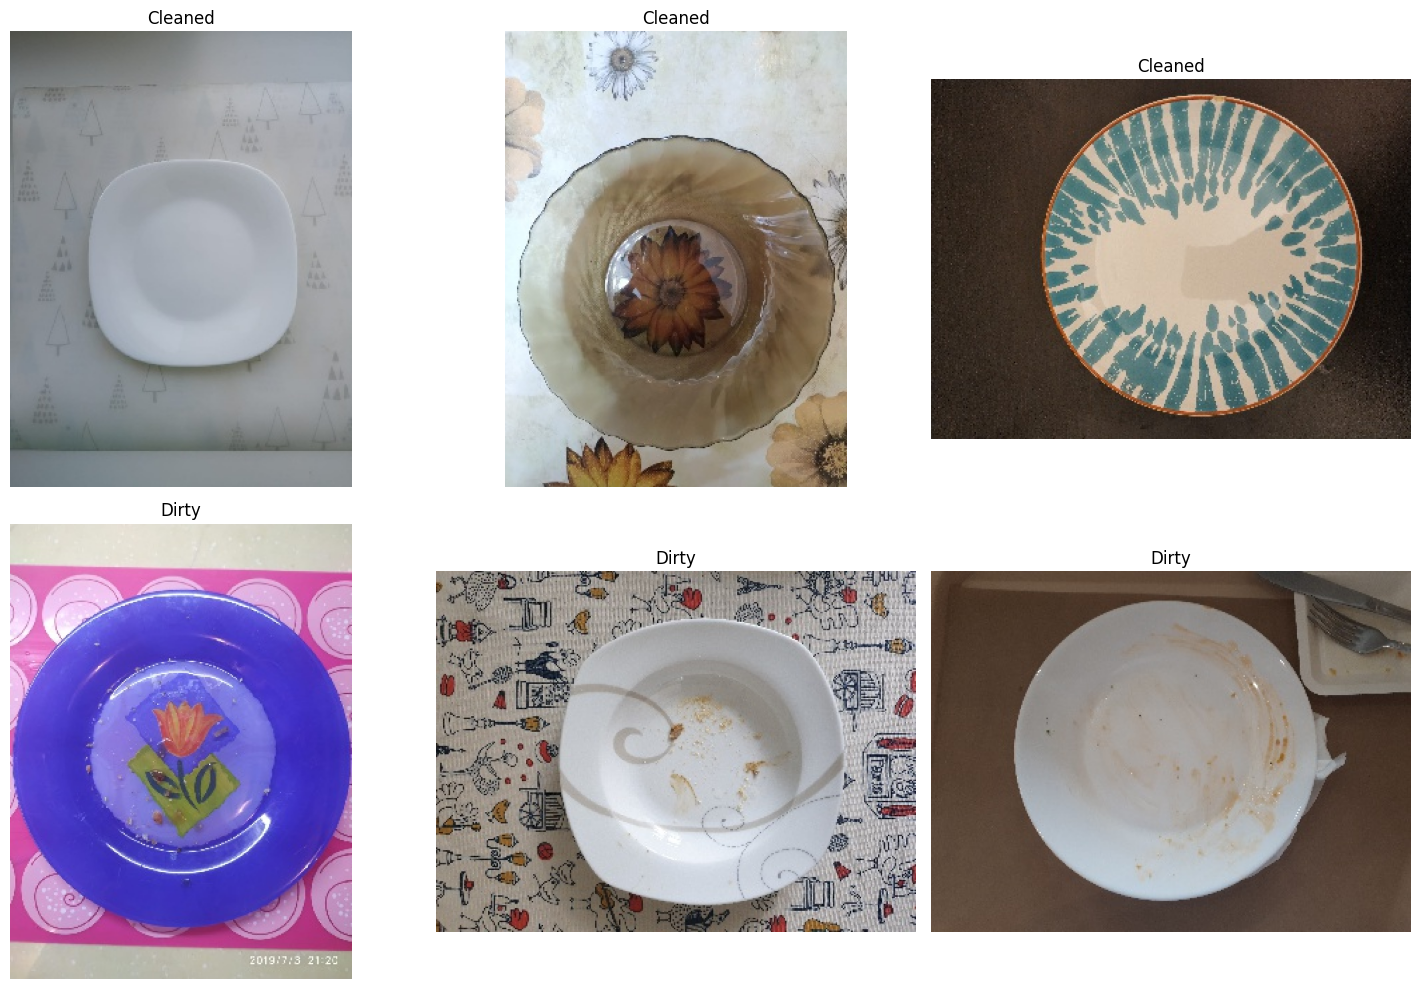

In [7]:
def show_images(df, labels, num_samples=3):
    """
    Belirli sınıflara ait fotoğrafları görselleştirir.
    """
    plt.figure(figsize=(15, len(labels) * 5))
    for i, label in enumerate(labels):
        sample_df = df[df['label'] == label].sample(num_samples)
        for j, (index, row) in enumerate(sample_df.iterrows()):
            img = cv2.imread(row['img'])  # Görüntüyü okuma
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB'ye dönüştürme
            plt.subplot(len(labels), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(label.capitalize())
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Kullanım: Her iki sınıftan 3'er adet fotoğraf göster
show_images(df, labels=['cleaned', 'dirty'], num_samples=3)


# Veri Ayıklama

In [8]:
# Eğitim ve test verilerini ayır
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['encode_label'])

print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Test seti boyutu: {len(test_df)}")

Eğitim seti boyutu: 32
Test seti boyutu: 8


In [9]:
class PlatesDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Görüntü yollarını ve etiketleri içeren DataFrame.
            transform (callable, optional): Dönüşüm işlemleri.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Görüntü yolu
        label = self.dataframe.iloc[idx, 2]    # Encode edilmiş etiket

        # Görüntüyü yükle ve dönüştür
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:

# Eğitim ve test seti ayırma
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Dataset sınıfları
train_dataset = PlatesDataset(train_df, transform=transform)
test_dataset = PlatesDataset(test_df, transform=transform)

# DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Eğitim veri sayısı: {len(train_dataset)}")
print(f"Test veri sayısı: {len(test_dataset)}")


Eğitim veri sayısı: 32
Test veri sayısı: 8


# Model seçimi ve Eğitimi

In [11]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3: RGB kanalları
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # 224x224 görüntü boyutu küçülecek
        self.fc2 = nn.Linear(128, 2)  # 2 sınıf: Cleaned ve Dirty

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli ve cihazı tanımla
model = SimpleCNN().to(device)
# Kayıp fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss()  # Çok sınıflı sınıflandırma için uygun
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
# Eğitim döngüsü
num_epochs = 10  # Kaç epoch çalıştırılacağı
for epoch in range(num_epochs):
    model.train()  # Modeli eğitim moduna geçir
    running_loss = 0.0  # Epoch başına kaybı hesaplamak için

    for images, labels in train_loader:
        # Görüntü ve etiketleri cihaza gönder
        images, labels = images.to(device), labels.to(device)

        # Optimizasyonu sıfırla
        optimizer.zero_grad()

        # İleri yayılım
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Geri yayılım ve optimizasyon
        loss.backward()
        optimizer.step()

        # Kayıp değerini topla
        running_loss += loss.item()

    # Her epoch sonunda kayıp değerini yazdır
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Eğitim tamamlandı!")


Epoch [1/10], Loss: 0.6908
Epoch [2/10], Loss: 2.9289
Epoch [3/10], Loss: 6.6763
Epoch [4/10], Loss: 3.3565
Epoch [5/10], Loss: 0.4781
Epoch [6/10], Loss: 1.4009
Epoch [7/10], Loss: 1.1344
Epoch [8/10], Loss: 0.6393
Epoch [9/10], Loss: 0.4135
Epoch [10/10], Loss: 0.3971
Eğitim tamamlandı!


In [14]:

# Tahminler ve gerçek etiketler için boş listeler oluştur
all_labels = []
all_predictions = []

# Modeli test etme
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Modelden tahmin al
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Tahminleri ve gerçek etiketleri listeye ekle
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# NumPy array'e dönüştür
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Performans metriklerini hesapla
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')  # Ağırlıklı ortalama
recall = recall_score(all_labels, all_predictions, average='weighted')        # Ağırlıklı ortalama
f1 = f1_score(all_labels, all_predictions, average='weighted')                # Ağırlıklı ortalama
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Performans metriklerini yazdır
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.5000
Precision: 0.3571
Recall (Sensitivity): 0.5000
F1-Score: 0.4167
Confusion Matrix:
[[4 1]
 [3 0]]


# Optimizasyon
Eğitim sonuçları çok düşük geldiği için veri seti değiştirmek ya da yeniden kod yazmak yerine optimizasyon yapmaya karar verdim.

In [15]:

# Veri artırma dönüşümleri
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ResNet18 Modeli (önceden eğitilmiş)
model = models.resnet18(pretrained=True)

# Son katmanı sınıflarımıza uyarlıyoruz
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 sınıf olduğu için

# Modeli cihazda çalıştır
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [16]:

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Daha iyi optimizasyon

In [17]:
num_epochs = 30
best_accuracy = 0
patience = 5  # Early stopping için sabır (kaç epoch bekleyeceğiz)
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Eğitim aşaması
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Test aşaması (doğruluğu ölçmek için)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

    # Early stopping kontrolü
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # En iyi modeli kaydet
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Erken durdurma tetiklendi.")
        break

print("Eğitim tamamlandı!")


Epoch [1/30], Loss: 0.8606, Accuracy: 62.50%
Epoch [2/30], Loss: 0.2548, Accuracy: 50.00%
Epoch [3/30], Loss: 0.0873, Accuracy: 62.50%
Epoch [4/30], Loss: 0.0374, Accuracy: 50.00%
Epoch [5/30], Loss: 0.0189, Accuracy: 62.50%
Epoch [6/30], Loss: 0.0107, Accuracy: 62.50%
Erken durdurma tetiklendi.
Eğitim tamamlandı!


In [18]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# Performans metriklerini hesapla
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Performans metrikleri
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.6250
Precision: 0.6562
Recall (Sensitivity): 0.6250
F1-Score: 0.6310
Confusion Matrix:
[[3 2]
 [1 2]]


Optimizasyon yaptıktan sonra değerler normale döndü. Yukarıdaki eğitimin sonucundan kat kat daha iyi bir performans elde edildi.